## Usefuls sources of informations:

* https://github.com/hbjornoy/deep-learning/blob/master/project2/helpers.py
* https://github.com/Ertugrulmert/EPFL-Deep-Learning-Projects/blob/master/Project_2/framework.py
* https://github.com/marieanselmet/DeepLearningEPFL_projects/tree/main/DL_framework_from_scratch

La grande différence est que tout le monde définit module avec un argument, et non une liste * -> à voir si on doit changer pour faire comme les années précédentes ou s'il y a qqc de plus pratique

## TODO

* Pour les modules retournant une empty list sur param, enlever la fonction param (ça sert à rien de l'override)

In [2]:
import torch
import math
import time
import datetime
import random

from torch import Tensor
torch.set_grad_enabled(False)

In [3]:
# The father of all Modules
class Module(object):
    def forward(self, *input):
        raise NotImplementedError
        
    def backward(self, *gradwrtoutput):
        raise NotImplementedError
        
    def param(self):
        return []

## Activation

À part ReLU et Tanh c'est pas précisé dans l'énoncé - là c'est juste pour le flex

In [4]:
class ReLU(Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, input):
        self.t = input
        return input.clamp(0)

    def backward(self, gradwrtoutput):
        input = self.t
        sign = input.sign().clamp(0)
        return sign * gradwrtoutput
        
    def param(self):
        return []

In [5]:
class Tanh(Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, input):
        self.t = input
        
        out = []
        for x in input :
            e = math.exp(-2 * x)
            val = (1 - e) / (1 + e)
            out.append(val)
        return torch.FloatTensor(out)

    def backward(self, gradwrtoutput):
        z = self.t
        e = torch.exp(-2 * z)
        d_tanh = 4 * e / (1 + e)**2
        return d_tanh * gradwrtoutput
        
    def param(self):
        return []

In [6]:
class Sigmoid(Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, input):
        self.t = input
        return input.mul(-1).exp().add(1).pow(-1)

    def backward(self, gradwrtoutput):
        sig = self.t.mul(-1).exp().add(1).pow(-1)
        return sig.mul(-1).add(1).mul(sig)
        
    def param(self):
        return []

## Layers

In [7]:
class Linear(Module):
    def __init__(self, input_size, output_size, mean=0, std=1):
        super().__init__()
        self.W = torch.empty(output_size, input_size).normal_(mean, std)
        self.b = torch.empty(output_size).normal_(mean, std)
        self.dW = torch.zeros(output_size, input_size)
        self.db = torch.zeros(output_size)
    def forward(self, input):
        self.t = input
        return self.W.mv(input).add(self.b)

    def backward(self, gradwrtoutput):
        self.dW.add_(gradwrtoutput.view(1, -1).t().mm(self.t.view(1, -1)))
        self.db.add_(gradwrtoutput)
        #print(gradwrtoutput.shape, self.W.shape)
        return self.W.t().mv(gradwrtoutput)
        
        
    def param(self):
        return [(self.W, self.dW), (self.b, self.db)]

In [8]:
class Dropout(Module):
    def __init__(self, p = 0.5):
        super().__init__()
        self.p = p
        
    def forward(self, input):
        for i in range(input.shape[0]):
            if random.random() < self.p : 
                input[i] = 0 
        return input
    
    def backward(self, gradwrtoutput):
        return gradwrtoutput
        
        
    def param(self):
        return []

In [9]:
l = Dropout(0.5)
t = torch.empty(10).fill_(1)
l.forward(t)

tensor([0., 1., 1., 1., 1., 1., 0., 1., 1., 1.])

## Sequential

Lui en input il prend une liste de modules et son fwd c'est de feed le fwd de chaque layer dans l'autre

In [10]:
class Sequential(Module):
    def __init__(self, module_list):
        super().__init__()
        self.modules = module_list
        
    def forward(self, input):
        x = input
        for module in self.modules :
            x = module.forward(x)
        return x 

    def backward(self, gradwrtoutput):
        x = gradwrtoutput
        for module in reversed(self.modules) :
            x = module.backward(x)
        return x
        
    def param(self):
        params = []
        for module in self.modules:
            #print(module.param())
            for par in module.param():
                params.append(par)
        return params

## Loss

Seule lossMSE est demandé

In [11]:
class LossMSE(Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, pred, target):
        self.pred = pred
        self.target = target
        return (pred - target.float()).pow(2).mean()
    
    # J'ai pas mis les arguments dans backward car je pars du principe que la MSE est la dernière fonction utilisée
    def backward(self):
        return 2 * (self.pred - self.target)
    
    def param(self):
        return []

In [12]:
class LossMAE(Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, pred, target):
        self.pred = pred
        self.target = target
        return (pred - target.float()).abs().mean()

    def backward(self):
        error = self.pred - self.target
        return error.sign()
        
    def param(self):
        return []

In [13]:
# Binary cross entropy loss
# Note: We need to use sigmoid function before using BCE otherwise it makes no sense
class LossBCE(Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, pred, target):
        self.pred = pred
        self.target = target
        #print(target * pred.log())
        return ((target * pred.log()) + ((1 - target) * (1 - pred).log())).mean()

    def backward(self):
        return ((-target/pred) + ((1 - target)/(1 - pred))).mean()
        
    def param(self):
        return []

## Optimizer

Pas demandé mais fancy

In [14]:
class SGD():
    def __init__(self, params, lr, seq = True):
        self.params = params
        self.lr = lr
        self.seq = seq
        print(len(self.params))
    def step(self): 
        for module in self.params:
            param, grad = module
            if (param is not None) and (grad is not None):
                param.sub_(grad, alpha=self.lr)
    
    def zero_grad(self):
        for module in self.params:
            param, grad = module
            if (param is not None) and (grad is not None):
                grad.zero_()
                    
    def show(self):
        # To remove, for debugging
        for idx, i in enumerate(self.params):
            print(idx, i)

In [15]:
class Adam():
    def __init__(self, params, lr, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-8):
        self.params = params
        self.lr = lr
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        
        # Adam inner values 
        self.t = 0
        self.adam_values = []
        for t in self.params:
            t0, t1 = t
            self.adam_values.append((torch.zeros_like(t0), torch.zeros_like(t1)))

    def step(self):
        self.t += 1 
        for idx_module, module in enumerate(self.params):
            param, grad = module
            if (param is not None) and (grad is not None):
                #Update Vd and Sd, for each tuple we keep vd and sd 
                vd, sd = self.adam_values[idx_module]

                vd.mul_(self.beta_1).add_(grad.mul(1 - self.beta_1))
                sd.mul_(self.beta_2).add_(grad.pow(2).mul(1 - self.beta_2))

                # Compute corrected Values
                vd_corr = vd.mul(torch.tensor([[self.beta_1]]).pow(self.t).mul(-1).add(1).pow(-1)) 
                sd_corr = sd.mul(torch.tensor([[self.beta_2]]).pow(self.t).mul(-1).add(1).pow(-1)) 

                # Update the parameter 
                v =sd_corr.sqrt().add(self.epsilon).pow(-1).mul(vd_corr)
                
                #print("param, v", param, param.shape, v, v.shape)
                param.sub_(v.reshape(param.shape), alpha=self.lr)

    def zero_grad(self):
        for module in self.params:
            param, grad = module
            if (param is not None) and (grad is not None):
                grad.zero_()
                    
    def show(self):
        # To remove, for debugging
        print(self.t)
        print("PARAMS : ")
        for i in self.params:
            print(i)
        print(("ADAM [Vd, Sd] : "))
        for i in self.adam_values:
            print(i)

## Data generation

In [16]:
def generate_disc_dataset(nb, seed=0):
    torch.manual_seed(seed)
    input = torch.empty(nb, 2).uniform_(0, 1)
    
    distance = torch.norm((input - torch.Tensor([[0.5, 0.5]])), 2, 1, True)
    target = distance.mul(math.sqrt(2*math.pi)).sub(1).sign().sub(1).div(-2).long()  
    return input, target

In [17]:
# Pas sûr de l'interêt du one hot encoder vu l'énoncé mais je peux me tromper 
def one_hot_encoder(target):
    return torch.empty(target.size(0), 2).zero_().scatter_(1, target.view(-1, 1), 1)

In [18]:
def split_dataset(input, target, train_perc):
    train_part = math.floor(target.size()[0] * train_perc)
    test_part = target.size()[0] - train_part
    
    train_input = input.narrow(0, 0, train_part)
    test_input = input.narrow(0, train_part, test_part)
    
    train_target = target.narrow(0, 0, train_part)
    test_target = target.narrow(0, train_part, test_part)
    
    return train_input, train_target, test_input, test_target

In [19]:
def normalize_data(train, test):
    mean, std = train.mean(), train.std()
    train = (train - mean) / std
    test = (test - mean) / std
    return train, test

<ipython-input-20-157b9d967744>:6: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370124688/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  zeros = input[(target == 0).nonzero()[:,0]]


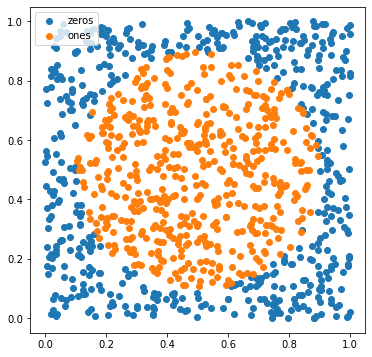

In [20]:
import matplotlib.pyplot as plt 

input, target = generate_disc_dataset(1000)

def plot_from_input(input, target):
    zeros = input[(target == 0).nonzero()[:,0]]
    ones = input[target.nonzero()[:,0]]
    plt.figure(figsize= (6,6))
    plt.scatter(zeros[:,0], zeros[:,1], label='zeros')
    plt.scatter(ones[:,0], ones[:,1], label= 'ones')
    plt.legend()
    plt.savefig('generated_data.png')
    plt.show()

plot_from_input(input, target)

## Train / Test

In [45]:
def train(model, train_input, train_target, loss_function, learning_rate=0.0001, nb_epochs=100):
    
    criterion = loss_function
    optimizer = SGD(model.param(), learning_rate)
    
    losses = []
    
    for epoch in range(nb_epochs):
        
        acc_loss = 0

        for idx, input in enumerate(train_input):
            optimizer.zero_grad()
            output = model.forward(input)
            target = train_target[idx]
            
            loss = criterion.forward(output, target)
            #print(output, target, loss.item())
            acc_loss = acc_loss + loss.item()
            
            grad_loss = criterion.backward()
            model.backward(grad_loss)
            optimizer.step()
        
        avg_acc_loss = acc_loss / train_input.shape[0]
        losses.append(avg_acc_loss)
        print(f"epoch {epoch}, Loss {avg_acc_loss}")
    return model, losses

def train_adam(model, train_input, train_target, loss_function, learning_rate=0.05, nb_epochs=100):
    
    criterion = loss_function
    optimizer = Adam(model.param(), learning_rate)
    losses = []

    for epoch in range(nb_epochs):
        
        acc_loss = 0

        for idx, input in enumerate(train_input):
            optimizer.zero_grad()
            output = model.forward(input)
            target = train_target[idx]
            
            loss = criterion.forward(output, target)
            #print(output, target, loss.item())
            acc_loss = acc_loss + loss.item()
            
            grad_loss = criterion.backward()
            model.backward(grad_loss)
            optimizer.step()
            
            
        losses.append(acc_loss)
        print(f"epoch {epoch}, Loss {acc_loss}")
    return model, losses


def test(model, test_input, test_label):
    nb_correct = 0
    nb_total = test_input.shape[0]
    x_0 = []
    y_0 = []
    x_1 = []
    y_1 = []
    
    for idx, input in enumerate(test_input):
        prediction = model.forward(input)
        target = test_label[idx]
        if prediction < 0.5 :
            x_0.append(input[0])
            y_0.append(input[1])
        else :
            x_1.append(input[0])
            y_1.append(input[1])
            
        nb_correct += (prediction > 0.5) == target
    plt.figure(figsize= (6,6))
    plt.scatter(x_0, y_0, label='zeros')
    plt.scatter(x_1, y_1, label= 'ones')
    plt.legend()
    plt.show()
    print(nb_correct, nb_total, 100 * nb_correct/nb_total)
    return  100 * nb_correct/nb_total

## Data creation and code 

Note: j'ai pas compris si on doit utiliser 1000 datasets pour le train + 1000 dataset pour le test, pour le moment j'ai fait 1000 pour les 2 et je split ensuite, à voir comment on veut faire 

Note: Si on veut faire un truc fancy et visualiser notre data, il faudrait faire l'opération "inverse" du normalize data sur le dataset 

TODO: lr hypertuning w/ validation ? 

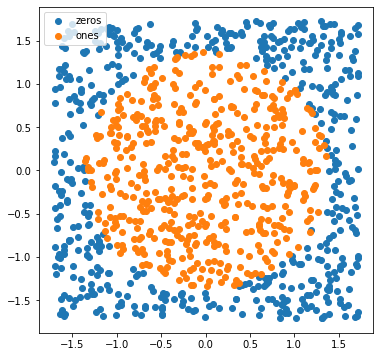

8
epoch 0, Loss 357.28380444956554
epoch 1, Loss 0.5275415033576617
epoch 2, Loss 0.42022821294116336
epoch 3, Loss 0.33905795873112493
epoch 4, Loss 0.2810191629980031
epoch 5, Loss 0.22458009390860462
epoch 6, Loss 0.1994921704459748
epoch 7, Loss 0.18570372129000917
epoch 8, Loss 0.176245163371251
epoch 9, Loss 0.16898560540596258
epoch 10, Loss 0.1627970333596685
epoch 11, Loss 0.15767233971929817
epoch 12, Loss 0.15306305696816214
epoch 13, Loss 0.1487608517873768
epoch 14, Loss 0.14491277683929218
epoch 15, Loss 0.14145962614981972
epoch 16, Loss 0.13848714929581882
epoch 17, Loss 0.13565846357984052
epoch 18, Loss 0.13296305935801628
epoch 19, Loss 0.13043707617278846
epoch 20, Loss 0.12813754878807118
epoch 21, Loss 0.1260830911485209
epoch 22, Loss 0.12410240436446077
epoch 23, Loss 0.12227732247266937
epoch 24, Loss 0.12049268909224875
epoch 25, Loss 0.11885634884362924
epoch 26, Loss 0.11718405624906592
epoch 27, Loss 0.11564297973626697
epoch 28, Loss 0.11419600797965249
ep

In [51]:
input, target = generate_disc_dataset(2000)
train_input, train_target, test_input, test_target = split_dataset(input, target, 0.5)
train_input, test_input = normalize_data(train_input, test_input)
plot_from_input(train_input, train_target)
# Pas sûr si on doit faire une activation fonction à la fin
model = Sequential([Linear(2, 25), ReLU(), Linear(25, 25), ReLU(), Linear(25, 25), ReLU(), Linear(25, 1)])

model, loss = train(model, train_input, train_target, LossMSE())

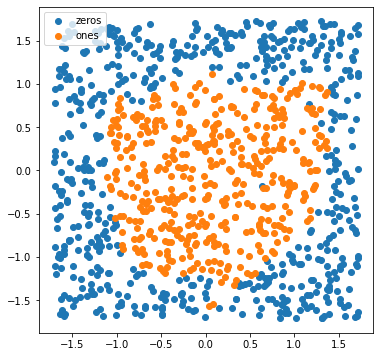

tensor([908]) 1000 tensor([90.8000])


In [52]:
accuracy_sgd_mse = test(model, train_input, train_target)

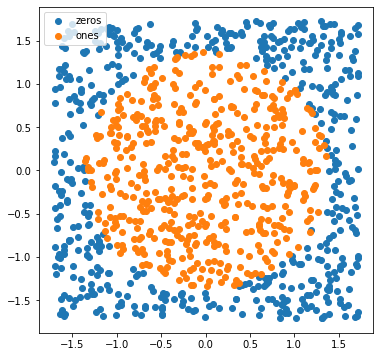

epoch 0, Loss 89300.5597778811
epoch 1, Loss 13937.709399799403
epoch 2, Loss 7169.064622955089
epoch 3, Loss 1159.0259843034698
epoch 4, Loss 2084.776090505343
epoch 5, Loss 666.5720213429927
epoch 6, Loss 936.2802158192719
epoch 7, Loss 459.2475697533564
epoch 8, Loss 379.52019794467765
epoch 9, Loss 225.757217037366
epoch 10, Loss 200.69311111303682
epoch 11, Loss 260.1783323807804
epoch 12, Loss 137.62511195726
epoch 13, Loss 84.7580342730672
epoch 14, Loss 126.22842078383701
epoch 15, Loss 274.8594072993419
epoch 16, Loss 272.6764893041878
epoch 17, Loss 271.9629697565797
epoch 18, Loss 271.49009499998647
epoch 19, Loss 271.0550561246346
epoch 20, Loss 270.5492085334845
epoch 21, Loss 269.9408142508473
epoch 22, Loss 269.1993678486906
epoch 23, Loss 268.32083786837757
epoch 24, Loss 267.4362276867032
epoch 25, Loss 266.84179784730077
epoch 26, Loss 266.46991592273116
epoch 27, Loss 266.1021537296474
epoch 28, Loss 265.7047171574086
epoch 29, Loss 265.27390926517546
epoch 30, Loss 

In [ ]:
input_adam, target_adam = generate_disc_dataset(2000)
train_input_adam, train_target_adam, test_input_adam, test_target_adam = split_dataset(input_adam, target_adam, 0.5)
train_input_adam, test_input_adam = normalize_data(train_input_adam, test_input_adam)
plot_from_input(train_input_adam, train_target_adam)
# Pas sûr si on doit faire une activation fonction à la fin
model_adam = Sequential([Linear(2, 25), ReLU(), Linear(25, 25), ReLU(), Linear(25, 25), ReLU(), Linear(25, 1)])

model_adam, loss_adam = train_adam(model_adam, train_input_adam, train_target_adam, LossMSE(), learning_rate=0.01, nb_epochs=500)

In [ ]:
accuracy_adam_mse = test(model_adam, test_input_adam, test_target_adam)

In [ ]:
input_BCE, target_BCE = generate_disc_dataset(2000)
train_input_BCE, train_target_BCE, test_input_BCE, test_target_BCE = split_dataset(input_BCE, target_BCE, 0.5)
train_input_BCE, test_input_BCE = normalize_data(train_input_BCE, test_input_BCE)
plot_from_input(train_input_BCE, train_target_BCE)
# Pas sûr si on doit faire une activation fonction à la fin
model_BCE = Sequential([Linear(2, 25), ReLU(), Linear(25, 25), ReLU(), Linear(25, 25), ReLU(), Linear(25, 1), Sigmoid()])

model_BCE, loss_BCE = train(model_BCE, train_input_BCE, train_target_BCE, LossBCE())

In [ ]:
accuracy_sgd_bce = test(model_BCE, test_input_BCE, test_target_BCE)

In [ ]:
input_adam_BCE, target_adam_BCE = generate_disc_dataset(2000)
train_input_adam_BCE, train_target_adam_BCE, test_input_adam_BCE, test_target_adam_BCE = split_dataset(input_adam_BCE, target_adam_BCE, 0.5)
train_input_adam_BCE, test_input_adam_BCE = normalize_data(train_input_adam_BCE, test_input_adam_BCE)
plot_from_input(train_input_adam_BCE, train_target_adam_BCE)
# Pas sûr si on doit faire une activation fonction à la fin
model_adam_BCE = Sequential([Linear(2, 25), ReLU(), Linear(25, 25), ReLU(), Linear(25, 25), ReLU(), Linear(25, 1), Sigmoid()])

model_adam_BCE, loss_adam_BCE = train_adam(model_adam_BCE, train_input_adam_BCE, train_target_adam_BCE, LossBCE(), learning_rate=0.01, nb_epochs=500)

In [ ]:
accuracy_adam_bce = test(model_adam_BCE, model_adam_BCE, model_adam_BCE)